In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from ruamel import yaml
import os
from load_cppimg import load_img
from MOLLI_fit import *
%matplotlib inline

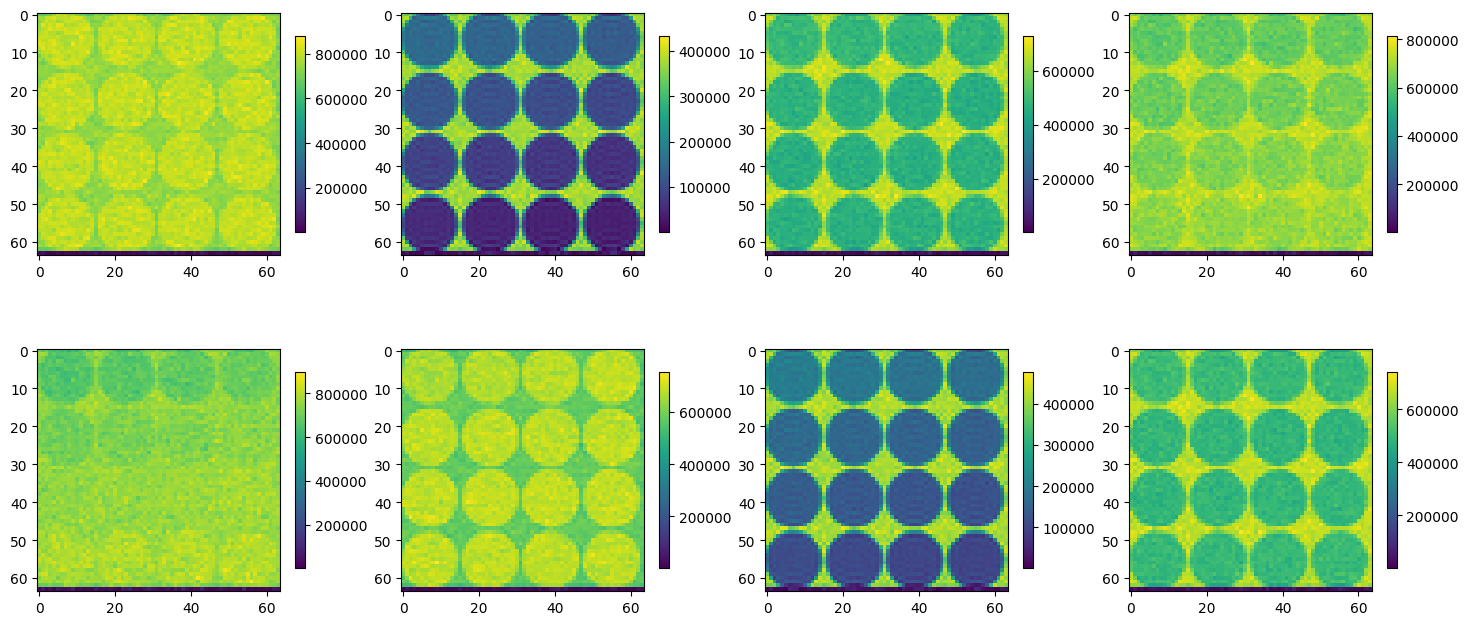

4096it [02:28, 27.57it/s]


[[ 1.18093801  1.19356338  1.17390255 ...  1.18823718  1.17949999
   1.186861  ]
 [ 1.19849949  1.1704828   1.37055479 ...  1.16511014  1.20153462
   1.17781562]
 [ 1.15296493  1.36514034  1.68700846 ...  1.37853144  1.15093713
   1.20983233]
 ...
 [ 1.19219348  1.15986492  1.43593432 ... 92.09154785  1.20351012
   1.16784585]
 [ 1.18706408  1.19601338  1.16912641 ...  1.20006288  1.18154263
   1.19232593]
 [ 1.54049126  1.04928756  0.95434721 ...  1.35580354  1.11381491
   1.07478242]]


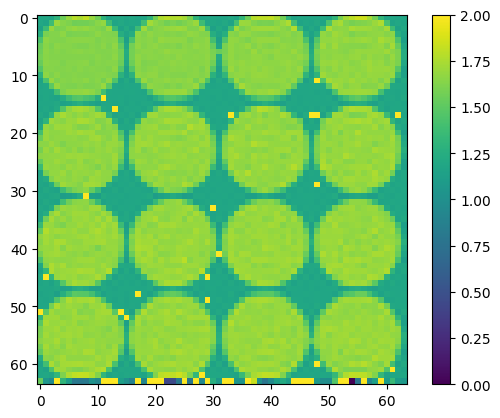

In [10]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array( [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        "../exp_result_slow/ID0_Speed_min0.0_max0.00967741935483871",i))
        # "../exp_result_slow/ID1_Speed_min0.01032258064516129_max0.02",i))
        # "../exp_result/ID0_Speed_min0.0_max0.029354207436399216",i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA35_FOV256_K64_thick8_center_first", i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA20_FOV320_K64_center_first", i))
        #  "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first_64^3",i))
        # "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first",i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

# print(MOLLI_readout_img[:, 15, 15])

plt.figure(figsize=(18,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])
    plt.colorbar(shrink=0.7)
plt.show()

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    # T1_star, T1, A, B = MAGIR(
    T1_star, T1, A, B = MF_MAGIR(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

print(T1_result)

plt.figure()
plt.imshow(T1_result)
plt.colorbar()
plt.clim(0,2)

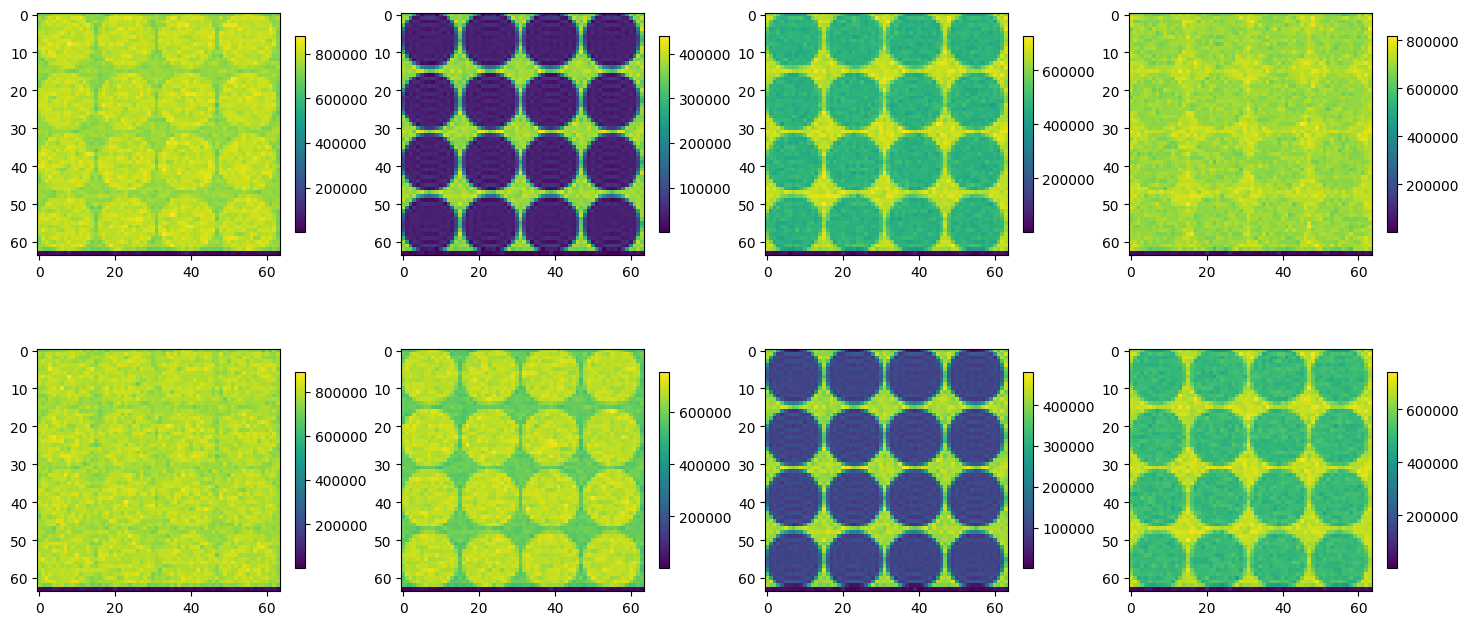

4096it [02:21, 28.99it/s]


[[1.17280471 1.20881857 1.15918216 ... 1.21826887 1.16021372 1.20190229]
 [1.1977131  1.16608958 1.4323147  ... 1.17423598 1.21028432 1.16745065]
 [1.15167914 1.4672969  1.75444516 ... 1.39824635 1.15440761 1.22062235]
 ...
 [1.2087079  1.1689875  1.43023693 ... 1.17371932 1.20763345 1.17193989]
 [1.16956237 1.19456959 1.1710176  ... 1.20074526 1.1681993  1.20273011]
 [0.81180896 1.18025502 1.30168837 ... 5.06355209 0.97682909 0.7732594 ]]


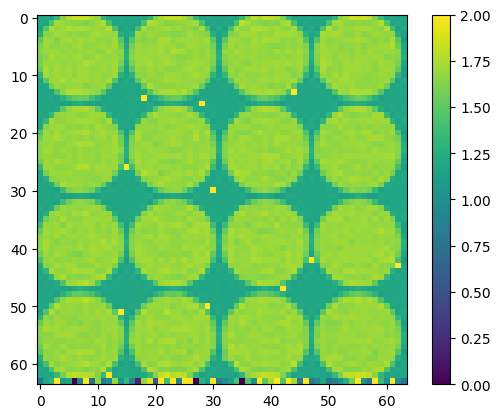

In [12]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array( [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        # "../exp_result_slow/ID0_Speed_min0.0_max0.00967741935483871",i))
        "../exp_result_slow/ID1_Speed_min0.01032258064516129_max0.02",i))
        # "../exp_result/ID0_Speed_min0.0_max0.029354207436399216",i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA35_FOV256_K64_thick8_center_first", i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA20_FOV320_K64_center_first", i))
        #  "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first_64^3",i))
        # "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first",i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

# print(MOLLI_readout_img[:, 15, 15])

plt.figure(figsize=(18,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])
    plt.colorbar(shrink=0.7)
plt.show()

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    # T1_star, T1, A, B = MAGIR(
    T1_star, T1, A, B = MF_MAGIR(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

print(T1_result)

plt.figure()
plt.imshow(T1_result)
plt.colorbar()
plt.clim(0,2)

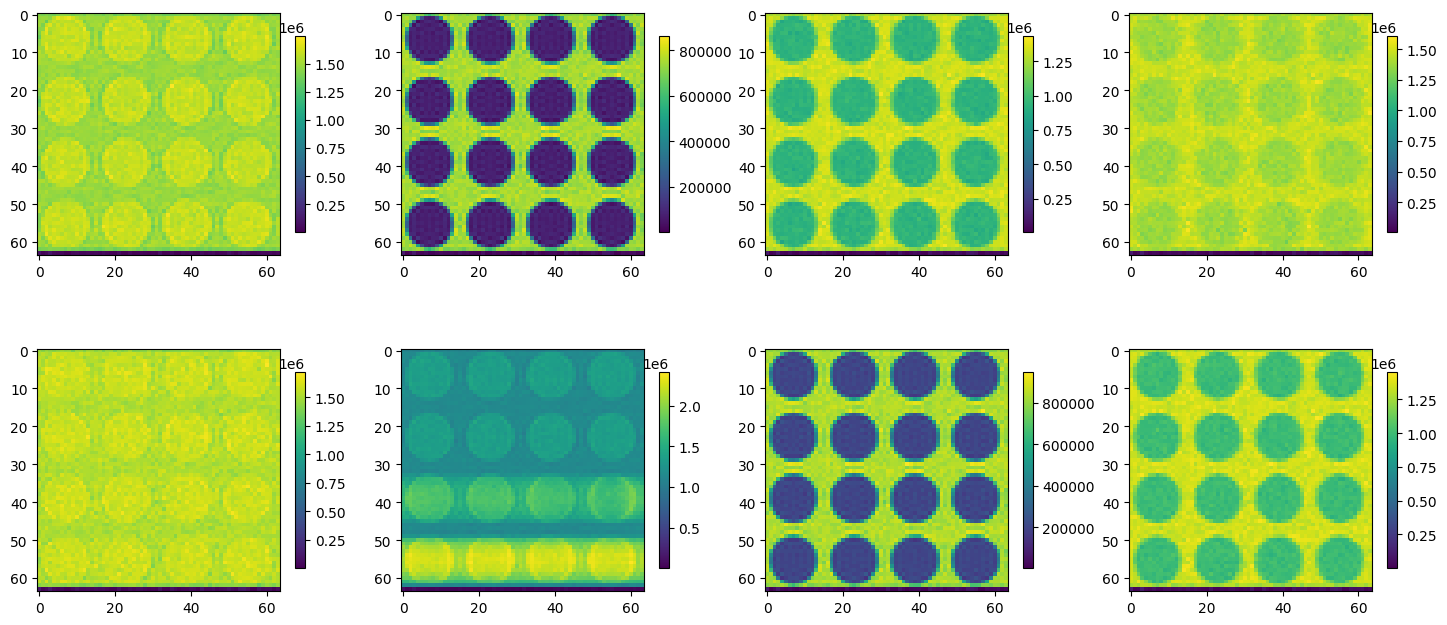

3it [00:00, 22.72it/s]/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
66it [00:02, 21.51it/s]/home/honght/undergraduate/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:29: RuntimeWarning: overflow encountered in exp
  return A - B * np.exp(-t / T1)
688it [00:25, 26.86it/s]/home/honght/undergraduate/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:29: RuntimeWarning: overflow encountered in multiply
  return A - B * np.exp(-t / T1)
4096it [02:47, 24.42it/s]


[[ 1.18297958  1.18947672  1.17756302 ...  1.17243544  1.19031871
   1.18108494]
 [ 1.18904721  1.17729984  1.19988715 ...  1.18994683  1.18723735
   1.18087733]
 [ 1.19028492  1.1946132   1.19025016 ...  1.20042136  1.17203417
   1.19437398]
 ...
 [ 1.3082176   1.32740723  1.30711426 ...  1.31540774  1.30109044
   1.30796568]
 [ 1.19845078  1.18501552  1.20360604 ...  1.19169298  1.20363922
   1.18608577]
 [10.67231566  1.53532784  1.34575221 ... 37.38411114  1.59965204
   1.27941508]]


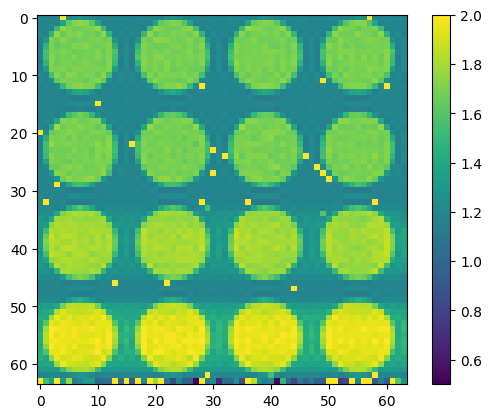

In [3]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array( [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        "../exp_result_ksp/ID0_Speed_min0.15_max0.17",i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA35_FOV256_K64_thick8_center_first", i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA20_FOV320_K64_center_first", i))
        #  "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first_64^3",i))
        # "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first",i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

# print(MOLLI_readout_img[:, 15, 15])

plt.figure(figsize=(18,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])
    plt.colorbar(shrink=0.7)
plt.show()

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    # T1_star, T1, A, B = MAGIR(
    T1_star, T1, A, B = MF_MAGIR(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

print(T1_result)

plt.figure()
plt.imshow(T1_result)
plt.colorbar()
plt.clim(0.5,2)

0it [00:00, ?it/s]/home/honght/miniconda3/envs/NUMERICAL/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
11it [00:00, 18.52it/s]/home/honght/undergraduate/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:29: RuntimeWarning: overflow encountered in exp
  return A - B * np.exp(-t / T1)
157it [00:05, 38.16it/s]/home/honght/undergraduate/Flow-Bloch-T1-mapping-cpp/python/MOLLI_fit.py:29: RuntimeWarning: overflow encountered in multiply
  return A - B * np.exp(-t / T1)
4096it [02:03, 33.06it/s]


[[  1.20581375  46.91191613   1.15722167 ...   1.13772189   1.27290319
    1.14706462]
 [ 10.59004836  62.26908962  10.31146511 ...   1.31179402   1.22665165
    6.80343807]
 [ 15.36933244   1.31697378   8.84873015 ...  16.82788775  20.76285365
    7.27237719]
 ...
 [  7.90116855  69.40857957  15.49530374 ...   7.95500335   1.18955815
    4.94405891]
 [  1.17265827   1.18637411   1.18314996 ...   1.1743467    1.14451899
    1.16091851]
 [  1.08092816   0.33886195   1.03636809 ...   1.40931051 107.57370992
    0.93748985]]


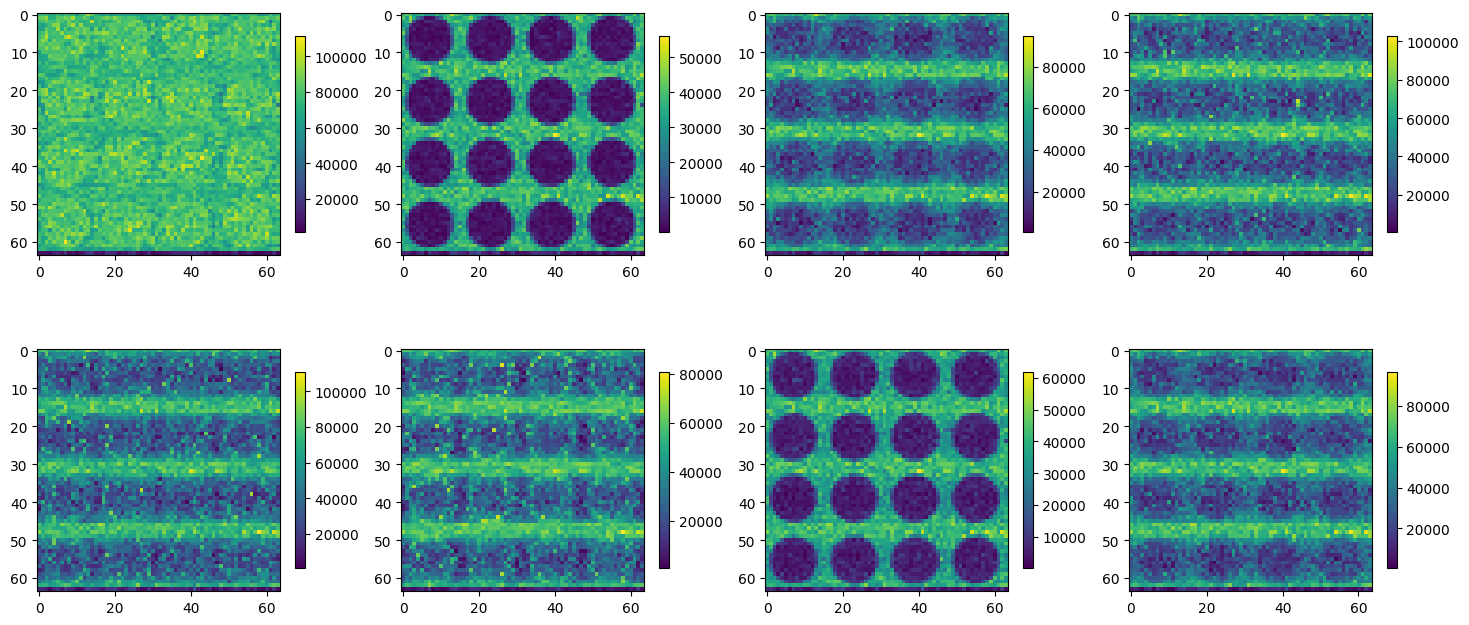

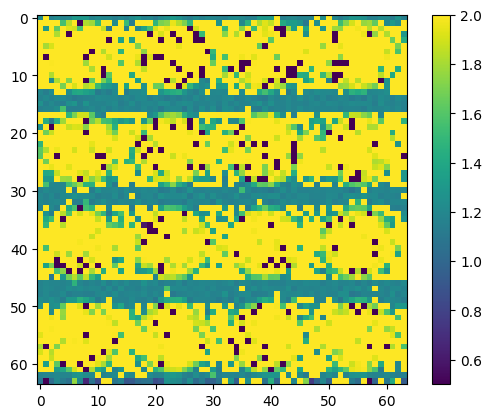

In [8]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array( [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        "../exp_result/ID31_Speed_min0.9706457925636007_max1.0",i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA35_FOV256_K64_thick8_center_first", i))
        # "../img_MOLLI/Phantom_MOLLI_533_TR2.8_FA20_FOV320_K64_center_first", i))
        #  "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first_64^3",i))
        # "../img_MOLLI/533_TR2.8_FA20_FOV320_K64_center_first",i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

# print(MOLLI_readout_img[:, 15, 15])

plt.figure(figsize=(18,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])
    plt.colorbar(shrink=0.7)

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    # T1_star, T1, A, B = MAGIR(
    T1_star, T1, A, B = MF_MAGIR(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

print(T1_result)

plt.figure()
plt.imshow(T1_result)
plt.colorbar()
plt.clim(0.5,2)